In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Load data
log_dir = 'logs/20251119_223306/'

inventory = pd.read_csv(log_dir + 'inventory_changes.csv')
messages = pd.read_csv(log_dir + 'messages.csv')
routes = pd.read_csv(log_dir + 'route_calculations.csv')
orders = pd.read_csv(log_dir + 'order_lifecycle.csv')
vehicles = pd.read_csv(log_dir + 'vehicle_metrics.csv')

print("📦 Data loaded successfully!")
print(f"   Inventory changes: {len(inventory)} records")
print(f"   Messages: {len(messages)} records")
print(f"   Route calculations: {len(routes)} records")
print(f"   Order lifecycle: {len(orders)} records")
print(f"   Vehicle metrics: {len(vehicles)} records")

📦 Data loaded successfully!
   Inventory changes: 474 records
   Messages: 4115 records
   Route calculations: 889 records
   Order lifecycle: 0 records
   Vehicle metrics: 0 records


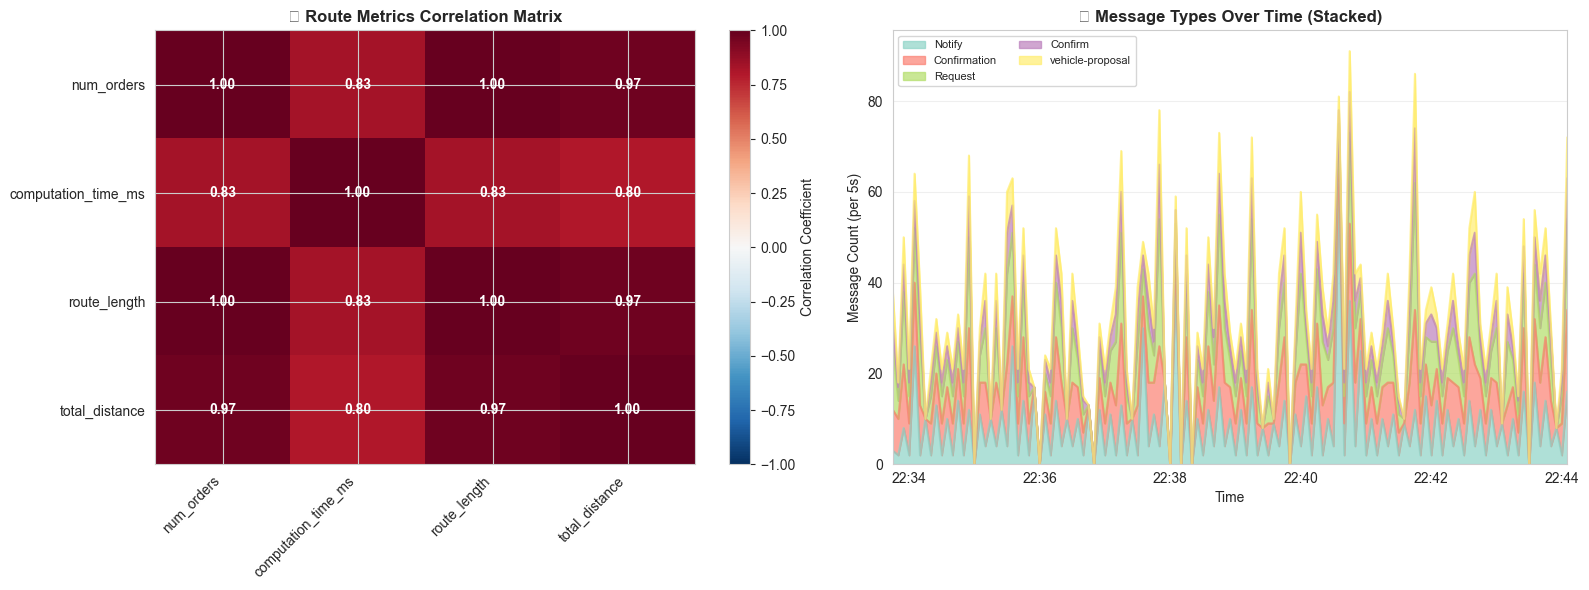


🔗 Correlation Insights:

Highest positive correlations:
   • num_orders ↔ computation_time_ms: 0.829
   • num_orders ↔ route_length: 1.000
   • num_orders ↔ total_distance: 0.969
   • computation_time_ms ↔ route_length: 0.829
   • computation_time_ms ↔ total_distance: 0.803
   • route_length ↔ total_distance: 0.969


In [2]:
# Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap for route calculations
route_corr = routes[['num_orders', 'computation_time_ms', 'route_length', 'total_distance']].corr()

im = axes[0].imshow(route_corr, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0].set_xticks(range(len(route_corr.columns)))
axes[0].set_yticks(range(len(route_corr.columns)))
axes[0].set_xticklabels(route_corr.columns, rotation=45, ha='right')
axes[0].set_yticklabels(route_corr.columns)
axes[0].set_title('🔗 Route Metrics Correlation Matrix', fontsize=12, fontweight='bold')

# Add correlation values
for i in range(len(route_corr)):
    for j in range(len(route_corr)):
        text = axes[0].text(j, i, f'{route_corr.iloc[i, j]:.2f}',
                          ha="center", va="center", color="white" if abs(route_corr.iloc[i, j]) > 0.5 else "black",
                          fontweight='bold', fontsize=10)

plt.colorbar(im, ax=axes[0], label='Correlation Coefficient')

# Message type timeline - stacked area
msg_types_timeline = messages.copy()
msg_types_timeline['timestamp_real'] = pd.to_datetime(msg_types_timeline['timestamp_real'])
msg_types_timeline = msg_types_timeline.set_index('timestamp_real')

# Get top message types
top_msg_types = messages['message_type'].value_counts().head(8).index

# Resample by time and count
timeline_data = {}
for msg_type in top_msg_types:
    timeline_data[msg_type] = msg_types_timeline[msg_types_timeline['message_type'] == msg_type].resample('5s').size()

# Create DataFrame
timeline_df = pd.DataFrame(timeline_data).fillna(0)

if len(timeline_df) > 0:
    timeline_df.plot.area(ax=axes[1], alpha=0.7, stacked=True, 
                         color=plt.cm.Set3(np.linspace(0, 1, len(top_msg_types))))
    axes[1].set_title('📊 Message Types Over Time (Stacked)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Message Count (per 5s)')
    axes[1].set_xlabel('Time')
    axes[1].legend(fontsize=8, loc='upper left', ncol=2)
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔗 Correlation Insights:")
print("\nHighest positive correlations:")
for i in range(len(route_corr.columns)):
    for j in range(i+1, len(route_corr.columns)):
        corr_val = route_corr.iloc[i, j]
        if corr_val > 0.5:
            print(f"   • {route_corr.columns[i]} ↔ {route_corr.columns[j]}: {corr_val:.3f}")

<Figure size 1200x600 with 0 Axes>

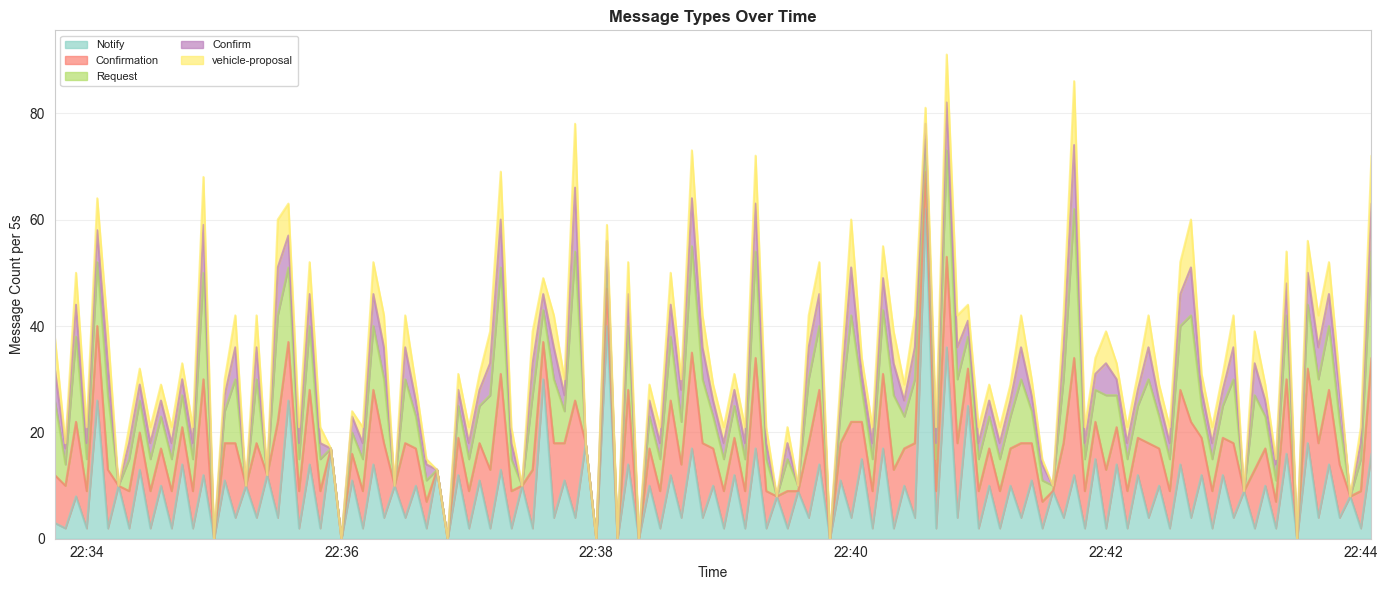

In [3]:
# Message type timeline
msg_types_timeline = messages.copy()
msg_types_timeline['timestamp_real'] = pd.to_datetime(msg_types_timeline['timestamp_real'])
msg_types_timeline = msg_types_timeline.set_index('timestamp_real')

top_msg_types = messages['message_type'].value_counts().head(8).index

timeline_data = {}
for msg_type in top_msg_types:
    timeline_data[msg_type] = msg_types_timeline[msg_types_timeline['message_type'] == msg_type].resample('5s').size()

timeline_df = pd.DataFrame(timeline_data).fillna(0)

plt.figure(figsize=(12, 6))

if len(timeline_df) > 0:
    timeline_df.plot.area(alpha=0.7, stacked=True, 
                          color=plt.cm.Set3(np.linspace(0, 1, len(top_msg_types))))
    plt.title('Message Types Over Time', fontsize=12, fontweight='bold')
    plt.ylabel('Message Count per 5s')
    plt.xlabel('Time')
    plt.legend(fontsize=8, loc='upper left', ncol=2)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



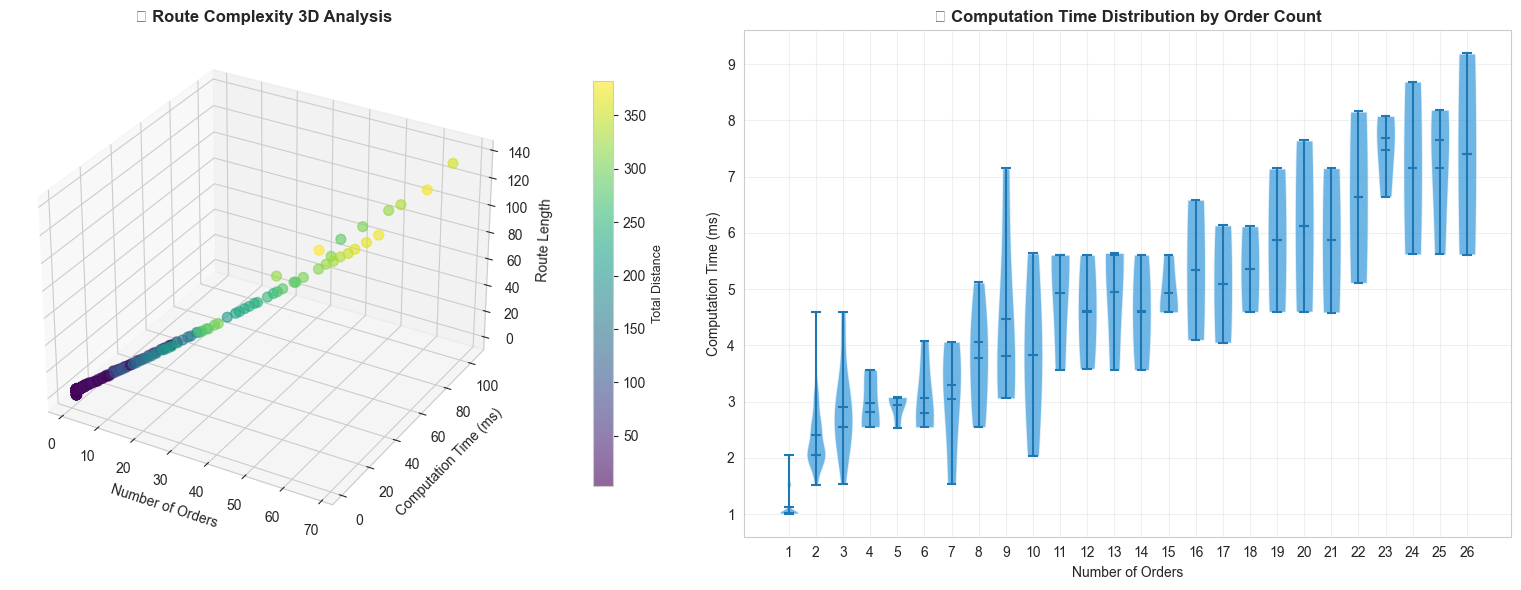

In [4]:
# 3D Scatter Plot - Route complexity
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# 3D scatter: num_orders vs computation_time vs route_length
ax1 = fig.add_subplot(121, projection='3d')

routes_3d = routes[routes['num_orders'] > 0]
if len(routes_3d) > 0:
    scatter = ax1.scatter(routes_3d['num_orders'], 
                         routes_3d['computation_time_ms'], 
                         routes_3d['route_length'],
                         c=routes_3d['total_distance'], 
                         cmap='viridis', s=50, alpha=0.6)
    
    ax1.set_xlabel('Number of Orders', fontsize=10)
    ax1.set_ylabel('Computation Time (ms)', fontsize=10)
    ax1.set_zlabel('Route Length', fontsize=10)
    ax1.set_title('🎯 Route Complexity 3D Analysis', fontsize=12, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax1, pad=0.1, shrink=0.8)
    cbar.set_label('Total Distance', fontsize=9)

# Violin plot - Computation time distribution by number of orders
ax2 = fig.add_subplot(122)

routes_violin = routes[routes['num_orders'] > 0]
if len(routes_violin) > 0:
    order_groups = routes_violin.groupby('num_orders')['computation_time_ms'].apply(list)
    
    positions = []
    data_to_plot = []
    labels = []
    
    for num_orders, times in order_groups.items():
        if len(times) > 1:  # Only plot if we have multiple data points
            positions.append(num_orders)
            data_to_plot.append(times)
            labels.append(str(int(num_orders)))
    
    if data_to_plot:
        parts = ax2.violinplot(data_to_plot, positions=positions, widths=0.7, 
                               showmeans=True, showmedians=True)
        
        for pc in parts['bodies']:
            pc.set_facecolor('#3498db')
            pc.set_alpha(0.7)
        
        ax2.set_xlabel('Number of Orders', fontsize=10)
        ax2.set_ylabel('Computation Time (ms)', fontsize=10)
        ax2.set_title('🎻 Computation Time Distribution by Order Count', fontsize=12, fontweight='bold')
        ax2.grid(alpha=0.3)
        ax2.set_xticks(positions)
        ax2.set_xticklabels(labels)

plt.tight_layout()
plt.show()

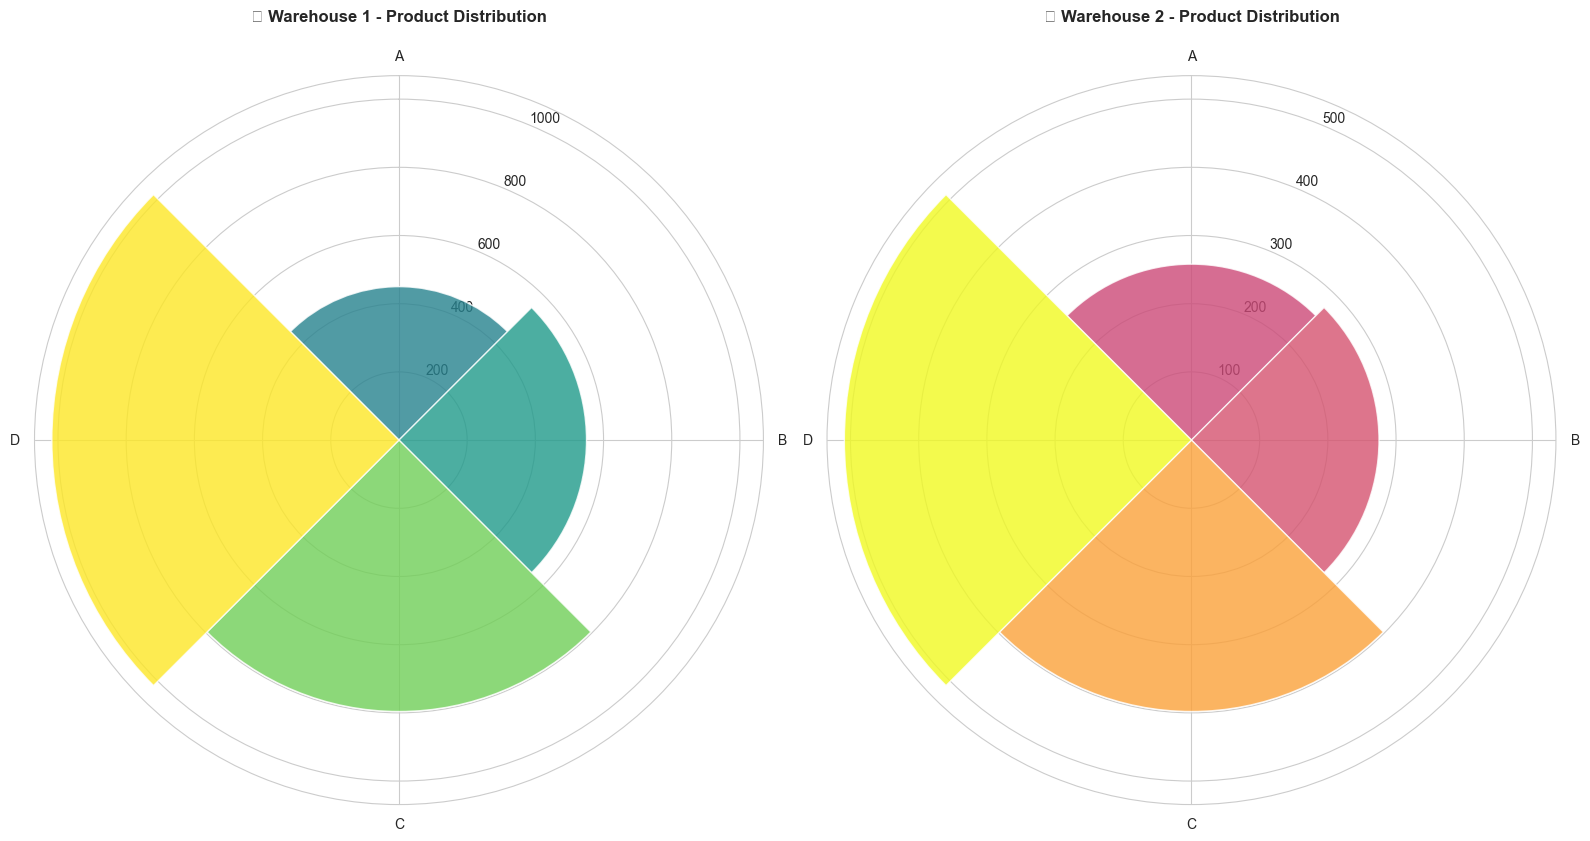

In [5]:
# Polar chart - Product distribution by warehouse
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(projection='polar'))

# Warehouse 1 product distribution
wh1_data = inventory[inventory['agent_jid'].str.contains('warehousee1', na=False)]
if len(wh1_data) > 0:
    product_dist = wh1_data.groupby('product')['quantity'].sum()
    
    theta = np.linspace(0, 2 * np.pi, len(product_dist), endpoint=False)
    radii = product_dist.values
    width = 2 * np.pi / len(product_dist)
    colors_polar = plt.cm.viridis(radii / radii.max())
    
    bars = axes[0].bar(theta, radii, width=width, bottom=0.0, color=colors_polar, alpha=0.8)
    axes[0].set_theta_zero_location('N')
    axes[0].set_theta_direction(-1)
    axes[0].set_title('🏭 Warehouse 1 - Product Distribution', fontsize=12, fontweight='bold', pad=20)
    axes[0].set_xticks(theta)
    axes[0].set_xticklabels(product_dist.index)

# Warehouse 2 product distribution
wh2_data = inventory[inventory['agent_jid'].str.contains('warehousee2', na=False)]
if len(wh2_data) > 0:
    product_dist2 = wh2_data.groupby('product')['quantity'].sum()
    
    theta2 = np.linspace(0, 2 * np.pi, len(product_dist2), endpoint=False)
    radii2 = product_dist2.values
    width2 = 2 * np.pi / len(product_dist2)
    colors_polar2 = plt.cm.plasma(radii2 / radii2.max())
    
    bars2 = axes[1].bar(theta2, radii2, width=width2, bottom=0.0, color=colors_polar2, alpha=0.8)
    axes[1].set_theta_zero_location('N')
    axes[1].set_theta_direction(-1)
    axes[1].set_title('🏭 Warehouse 2 - Product Distribution', fontsize=12, fontweight='bold', pad=20)
    axes[1].set_xticks(theta2)
    axes[1].set_xticklabels(product_dist2.index)

plt.tight_layout()
plt.show()

# 🎨 Bonus: Creative Visualizations

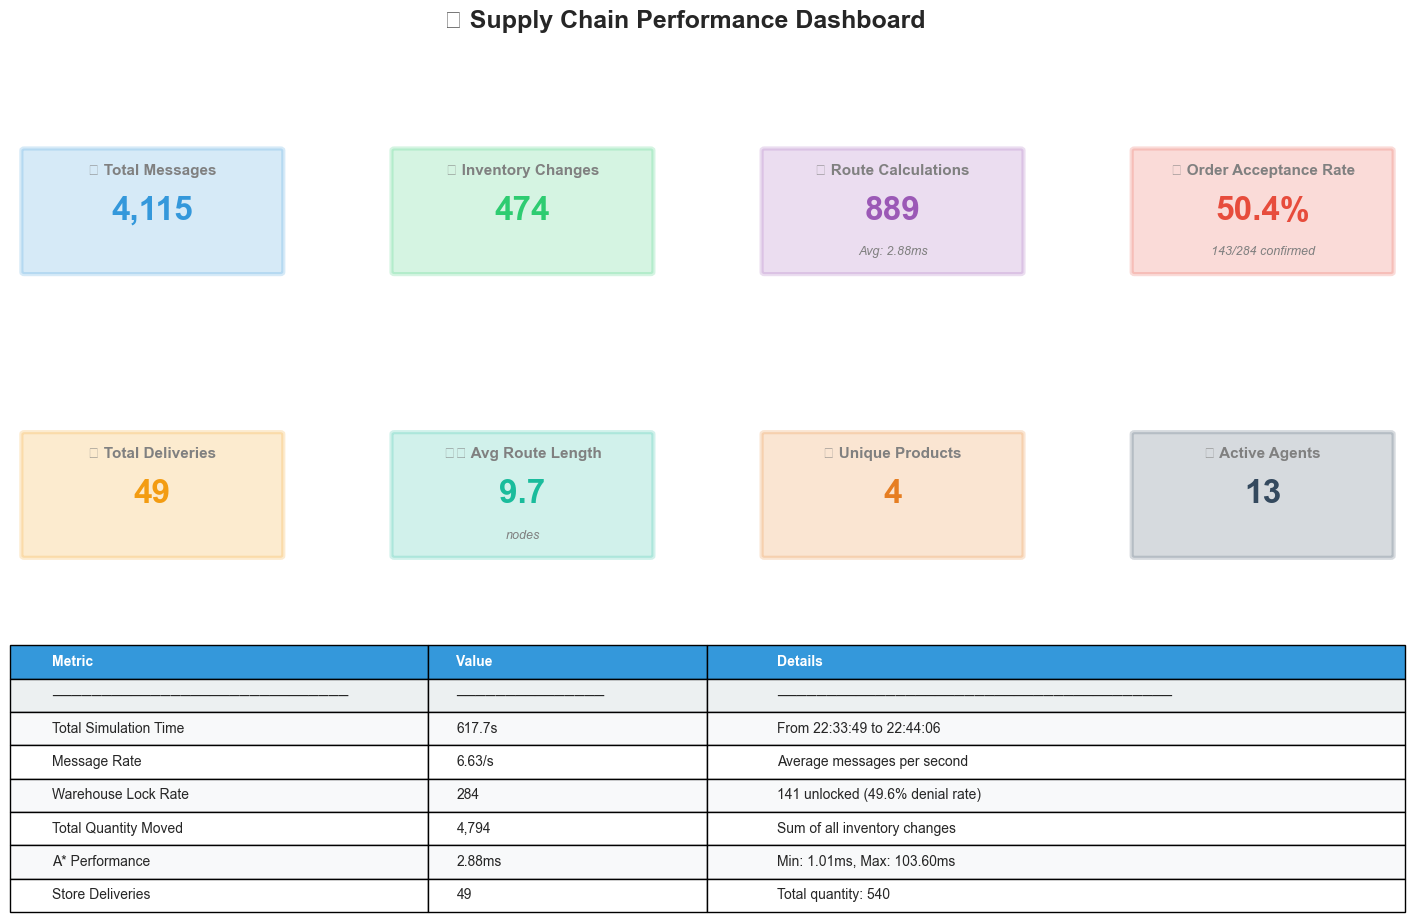

In [6]:
# Comprehensive KPI Dashboard
from matplotlib.patches import FancyBboxPatch

# Conversão necessária
inventory['timestamp_real'] = pd.to_datetime(inventory['timestamp_real'])
messages['timestamp_real'] = pd.to_datetime(messages['timestamp_real'])
routes['timestamp_real'] = pd.to_datetime(routes['timestamp_real'], errors='ignore')

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

def create_kpi_box(ax, title, value, subtitle="", color='#3498db'):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    box = FancyBboxPatch((0.5, 2), 9, 6, boxstyle="round,pad=0.1",
                         edgecolor=color, facecolor=color, alpha=0.2, linewidth=3)
    ax.add_patch(box)
    ax.text(5, 7, title, ha='center', va='center', fontsize=11, fontweight='bold', color='gray')
    ax.text(5, 5, str(value), ha='center', va='center', fontsize=24, fontweight='bold', color=color)
    if subtitle:
        ax.text(5, 3, subtitle, ha='center', va='center', fontsize=9, color='gray', style='italic')

ax1 = fig.add_subplot(gs[0, 0])
create_kpi_box(ax1, "📨 Total Messages", f"{len(messages):,}", color='#3498db')

ax2 = fig.add_subplot(gs[0, 1])
create_kpi_box(ax2, "📦 Inventory Changes", f"{len(inventory):,}", color='#2ecc71')

ax3 = fig.add_subplot(gs[0, 2])
create_kpi_box(ax3, "🚗 Route Calculations", f"{len(routes):,}",
               f"Avg: {routes['computation_time_ms'].mean():.2f}ms", color='#9b59b6')

locks = inventory[inventory['change_type'] == 'lock'].shape[0]
denials = inventory[inventory['change_type'].str.contains('unlock', na=False)].shape[0]
efficiency = ((locks - denials) / locks * 100) if locks > 0 else 0

ax4 = fig.add_subplot(gs[0, 3])
create_kpi_box(ax4, "✅ Order Acceptance Rate", f"{efficiency:.1f}%",
               f"{locks - denials}/{locks} confirmed", color='#e74c3c')

deliveries = inventory[inventory['change_type'] == 'delivery'].shape[0]
ax5 = fig.add_subplot(gs[1, 0])
create_kpi_box(ax5, "🚚 Total Deliveries", f"{deliveries}", color='#f39c12')

ax6 = fig.add_subplot(gs[1, 1])
create_kpi_box(ax6, "🛣️ Avg Route Length", f"{routes['route_length'].mean():.1f}",
               "nodes", color='#1abc9c')

unique_products = inventory['product'].nunique()
ax7 = fig.add_subplot(gs[1, 2])
create_kpi_box(ax7, "📊 Unique Products", f"{unique_products}", color='#e67e22')

unique_agents = pd.concat([messages['sender'], messages['receiver']]).nunique()
ax8 = fig.add_subplot(gs[1, 3])
create_kpi_box(ax8, "🤖 Active Agents", f"{unique_agents}", color='#34495e')

ax_table = fig.add_subplot(gs[2, :])
ax_table.axis('tight')
ax_table.axis('off')

performance_data = [
    ['Metric', 'Value', 'Details'],
    ['─' * 30, '─' * 15, '─' * 40],
    ['Total Simulation Time', f"{(inventory['timestamp_real'].max() - inventory['timestamp_real'].min()).total_seconds():.1f}s",
     f"From {inventory['timestamp_real'].min().strftime('%H:%M:%S')} to {inventory['timestamp_real'].max().strftime('%H:%M:%S')}"],
    ['Message Rate', f"{len(messages) / max((messages['timestamp_real'].max() - messages['timestamp_real'].min()).total_seconds(), 1):.2f}/s",
     'Average messages per second'],
    ['Warehouse Lock Rate', f"{locks}", f"{denials} unlocked ({denials/locks*100:.1f}% denial rate)"],
    ['Total Quantity Moved', f"{inventory['quantity'].sum():,}", 'Sum of all inventory changes'],
    ['A* Performance', f"{routes['computation_time_ms'].mean():.2f}ms",
     f"Min: {routes['computation_time_ms'].min():.2f}ms, Max: {routes['computation_time_ms'].max():.2f}ms"],
    ['Store Deliveries', f"{inventory[inventory['agent_type'] == 'store'].shape[0]}",
     f"Total quantity: {inventory[inventory['agent_type'] == 'store']['quantity'].sum()}"],
]

table = ax_table.table(cellText=performance_data, cellLoc='left', loc='center',
                       colWidths=[0.3, 0.2, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(3):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(3):
    table[(1, i)].set_facecolor('#ecf0f1')

for i in range(2, len(performance_data)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f8f9fa')
        else:
            table[(i, j)].set_facecolor('white')

plt.suptitle('📊 Supply Chain Performance Dashboard', fontsize=18, fontweight='bold', y=0.98)
plt.show()


# 📈 Summary Statistics & KPIs

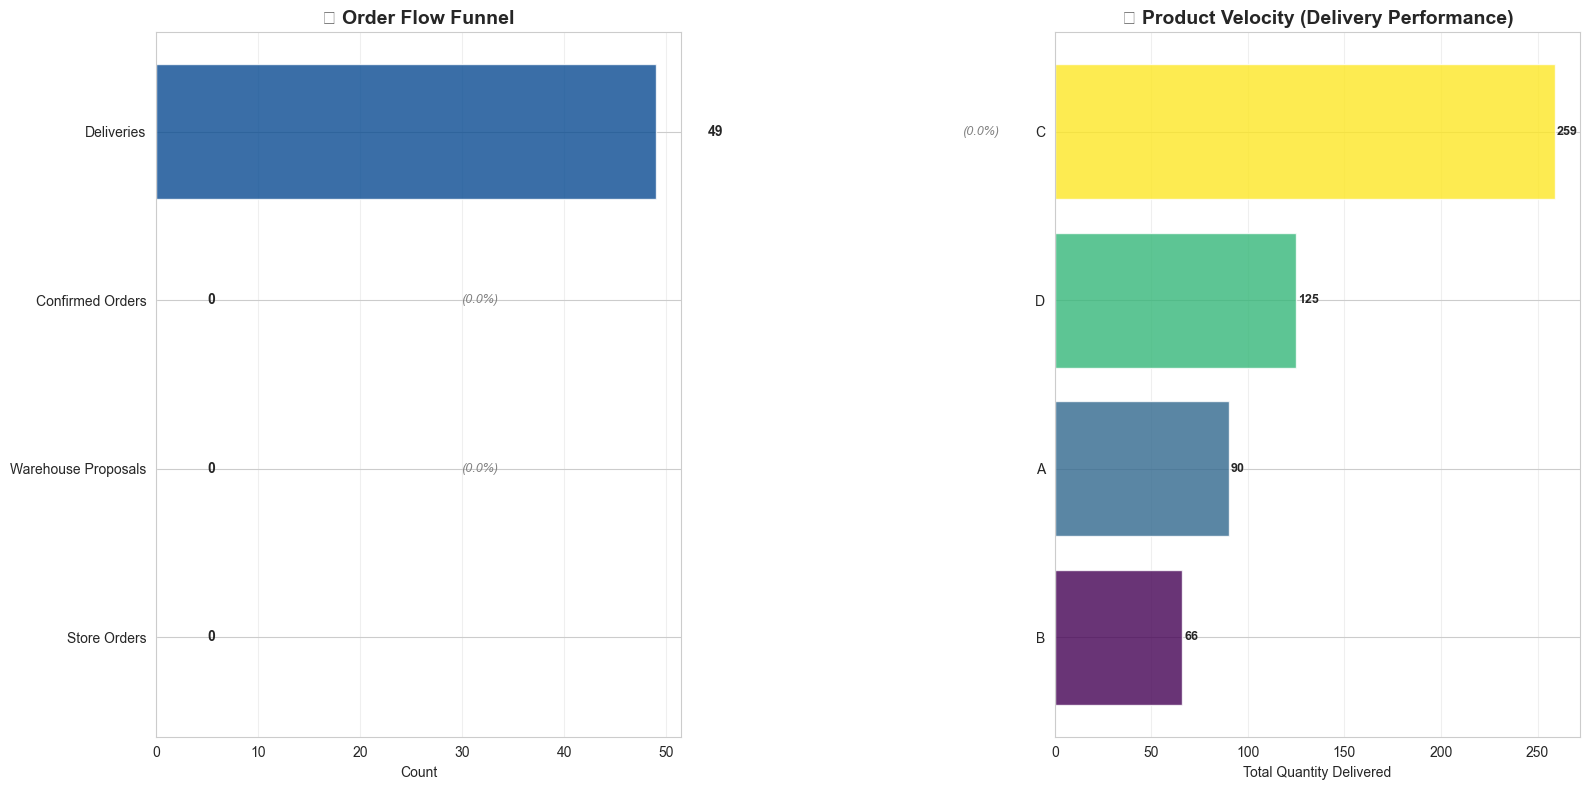


🔄 Order Flow Conversion Rates:
   Store Orders → Warehouse Proposals: 0.0%
   Warehouse Proposals → Confirmed Orders: 0.0%
   Confirmed Orders → Deliveries: 0.0%


In [7]:
# Network Flow Visualization - Sankey-like analysis
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Order flow: Store -> Warehouse -> Store (via vehicle)
store_orders = messages[messages['message_type'] == 'store-buy'].groupby('sender').size()
warehouse_accepts = messages[messages['message_type'] == 'warehouse-accept'].groupby('sender').size()
store_confirms = messages[messages['message_type'] == 'store-confirm'].groupby('sender').size()
deliveries = inventory[inventory['change_type'] == 'delivery'].groupby('agent_jid').size()

# Flow diagram data
flow_data = {
    'Store Orders': store_orders.sum(),
    'Warehouse Proposals': warehouse_accepts.sum(),
    'Confirmed Orders': store_confirms.sum(),
    'Deliveries': deliveries.sum()
}

# Create funnel chart
stages = list(flow_data.keys())
values = list(flow_data.values())
colors_funnel = plt.cm.Blues(np.linspace(0.4, 0.9, len(stages)))

y_pos = np.arange(len(stages))
axes[0].barh(y_pos, values, color=colors_funnel, alpha=0.8)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(stages)
axes[0].set_xlabel('Count')
axes[0].set_title('🔄 Order Flow Funnel', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add conversion rates
for i in range(len(values)):
    axes[0].text(values[i] + 5, i, f'{values[i]}', va='center', fontweight='bold')
    if i > 0:
        conversion = (values[i] / values[i-1] * 100) if values[i-1] > 0 else 0
        axes[0].text(values[i] + 30, i, f'({conversion:.1f}%)', va='center', 
                    fontsize=9, color='gray', style='italic')

# Product velocity - which products move fastest?
product_velocity = inventory[inventory['change_type'] == 'delivery'].groupby('product')['quantity'].sum()
product_velocity = product_velocity.sort_values(ascending=True)

axes[1].barh(range(len(product_velocity)), product_velocity.values,
            color=plt.cm.viridis(np.linspace(0, 1, len(product_velocity))), alpha=0.8)
axes[1].set_yticks(range(len(product_velocity)))
axes[1].set_yticklabels(product_velocity.index)
axes[1].set_xlabel('Total Quantity Delivered')
axes[1].set_title('🚀 Product Velocity (Delivery Performance)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, (prod, val) in enumerate(product_velocity.items()):
    axes[1].text(val + 1, i, f'{val}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔄 Order Flow Conversion Rates:")
for i in range(1, len(stages)):
    conversion = (values[i] / values[i-1] * 100) if values[i-1] > 0 else 0
    print(f"   {stages[i-1]} → {stages[i]}: {conversion:.1f}%")

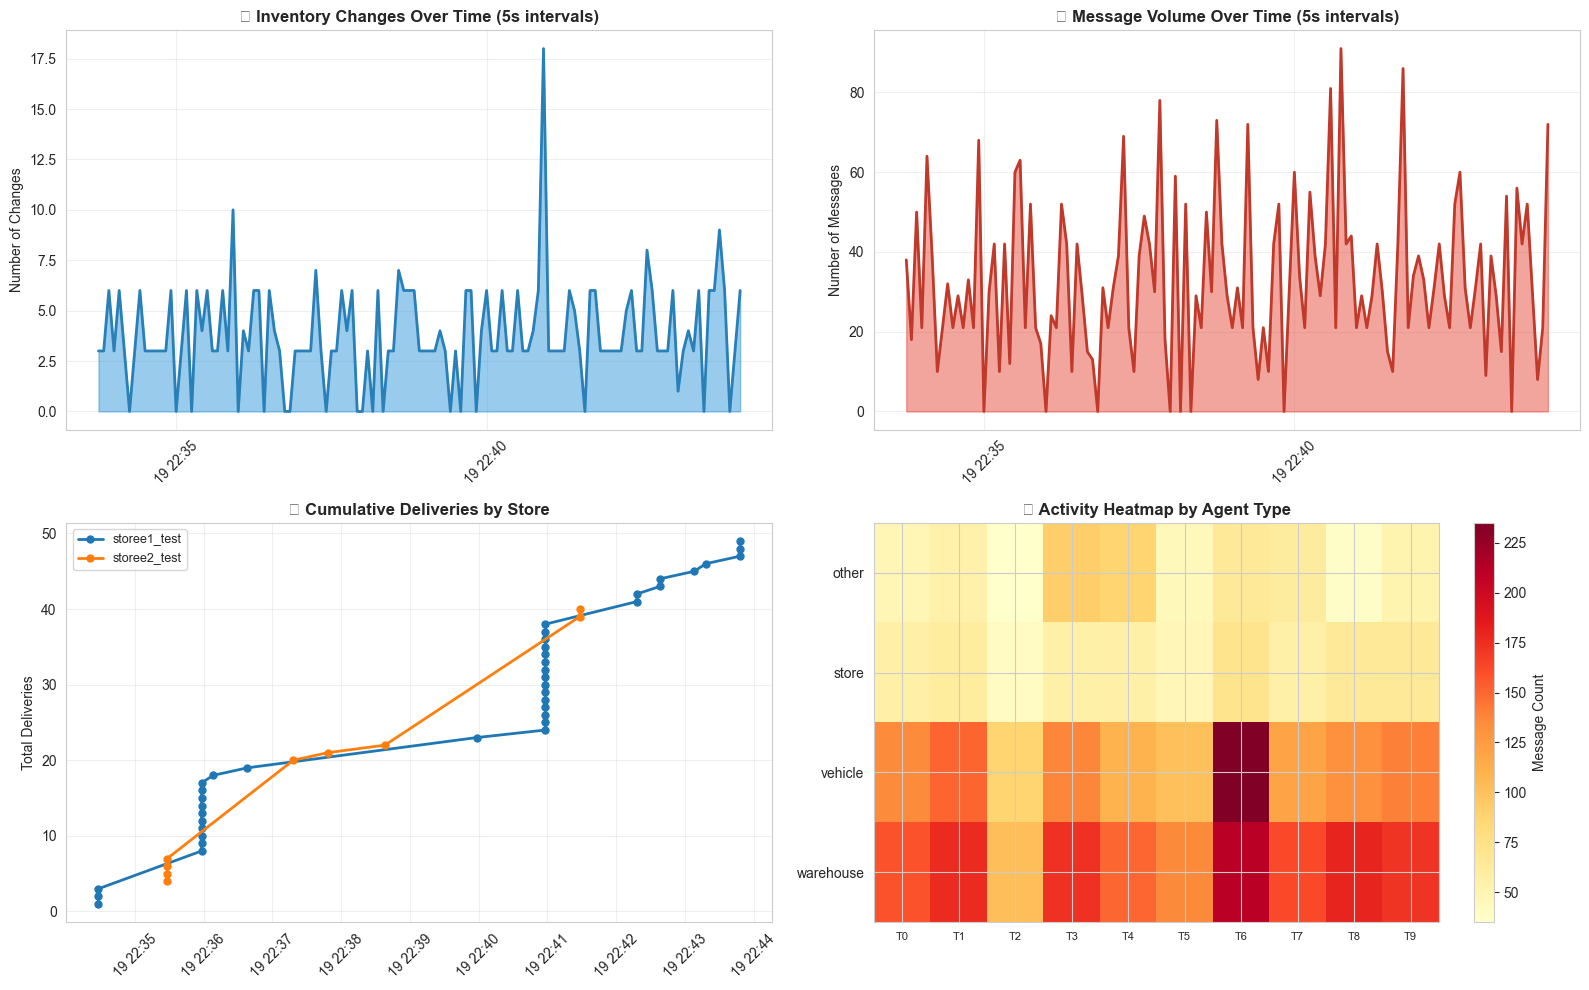

In [8]:
# Time-based Analysis - Activity patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Convert timestamps
inventory['timestamp_real'] = pd.to_datetime(inventory['timestamp_real'])
messages['timestamp_real'] = pd.to_datetime(messages['timestamp_real'])

# Inventory changes over time
inv_timeline = inventory.set_index('timestamp_real').resample('5s').size()
axes[0, 0].fill_between(inv_timeline.index, inv_timeline.values, alpha=0.5, color='#3498db')
axes[0, 0].plot(inv_timeline.index, inv_timeline.values, color='#2980b9', linewidth=2)
axes[0, 0].set_title('📦 Inventory Changes Over Time (5s intervals)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Changes')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Message volume over time
msg_timeline = messages.set_index('timestamp_real').resample('5s').size()
axes[0, 1].fill_between(msg_timeline.index, msg_timeline.values, alpha=0.5, color='#e74c3c')
axes[0, 1].plot(msg_timeline.index, msg_timeline.values, color='#c0392b', linewidth=2)
axes[0, 1].set_title('📨 Message Volume Over Time (5s intervals)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Messages')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Cumulative deliveries to stores
store_deliveries = inventory[inventory['change_type'] == 'delivery'].copy()
if len(store_deliveries) > 0:
    store_deliveries = store_deliveries.sort_values('timestamp_real')
    store_deliveries['cumulative'] = range(1, len(store_deliveries) + 1)
    
    for store in store_deliveries['agent_jid'].unique():
        store_data = store_deliveries[store_deliveries['agent_jid'] == store]
        axes[1, 0].plot(store_data['timestamp_real'], store_data['cumulative'], 
                       marker='o', label=store.split('@')[0], linewidth=2, markersize=5)
    
    axes[1, 0].set_title('📈 Cumulative Deliveries by Store', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Total Deliveries')
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)

# Activity heatmap by agent type and time
time_bins = pd.cut(messages['timestamp_real'], bins=10)
agent_types = messages['sender'].apply(lambda x: 'warehouse' if 'warehouse' in str(x).lower() 
                                        else ('store' if 'store' in str(x).lower() 
                                        else ('vehicle' if 'vehicle' in str(x).lower() else 'other')))
heatmap_data = pd.crosstab(agent_types, time_bins)

im = axes[1, 1].imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_yticks(range(len(heatmap_data.index)))
axes[1, 1].set_yticklabels(heatmap_data.index)
axes[1, 1].set_xticks(range(len(heatmap_data.columns)))
axes[1, 1].set_xticklabels([f'T{i}' for i in range(len(heatmap_data.columns))], fontsize=8)
axes[1, 1].set_title('🔥 Activity Heatmap by Agent Type', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1, 1], label='Message Count')

plt.tight_layout()
plt.show()

KeyError: 'win_rate'

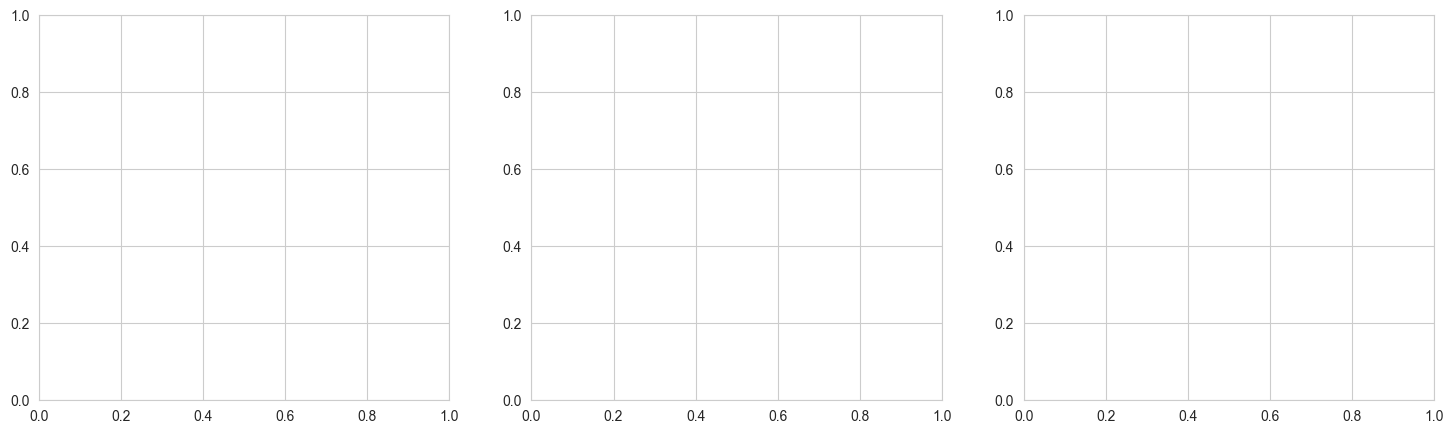

In [9]:
# Warehouse Competition Analysis - Which warehouse wins more orders?
warehouse_msgs = messages[messages['message_type'].isin(['warehouse-accept', 'warehouse-reject', 'store-confirm'])]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Warehouse proposals
proposals = messages[messages['message_type'] == 'warehouse-accept'].groupby('sender').size()
proposals.index = [x.split('@')[0] for x in proposals.index]

# Warehouse confirmations (wins)
confirmations = messages[messages['message_type'] == 'store-confirm'].groupby('receiver').size()
confirmations.index = [x.split('@')[0] for x in confirmations.index]

# Win rate
warehouses = list(set(proposals.index) | set(confirmations.index))
win_data = []
for wh in warehouses:
    prop = proposals.get(wh, 0)
    conf = confirmations.get(wh, 0)
    win_rate = (conf / prop * 100) if prop > 0 else 0
    win_data.append({'warehouse': wh, 'proposals': prop, 'wins': conf, 'win_rate': win_rate})

win_df = pd.DataFrame(win_data).sort_values('win_rate', ascending=False)

# Plot proposals vs wins
x = np.arange(len(win_df))
width = 0.35
axes[0].bar(x - width/2, win_df['proposals'], width, label='Proposals', color='#3498db', alpha=0.7)
axes[0].bar(x + width/2, win_df['wins'], width, label='Wins', color='#2ecc71', alpha=0.7)
axes[0].set_xticks(x)
axes[0].set_xticklabels(win_df['warehouse'], rotation=45, ha='right')
axes[0].set_ylabel('Count')
axes[0].set_title('🏆 Warehouse Proposals vs Wins', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Win rate
colors_grad = plt.cm.RdYlGn(win_df['win_rate'] / 100)
axes[1].barh(range(len(win_df)), win_df['win_rate'], color=colors_grad, alpha=0.8)
axes[1].set_yticks(range(len(win_df)))
axes[1].set_yticklabels(win_df['warehouse'])
axes[1].set_xlabel('Win Rate (%)')
axes[1].set_title('📊 Warehouse Win Rate', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Product preference by warehouse
warehouse_products = inventory[inventory['agent_type'] == 'warehouse'].groupby(['agent_jid', 'product'])['quantity'].sum().unstack(fill_value=0)
warehouse_products.index = [x.split('@')[0] for x in warehouse_products.index]
warehouse_products.plot(kind='bar', stacked=True, ax=axes[2], 
                        color=plt.cm.Set3(np.linspace(0, 1, len(warehouse_products.columns))))
axes[2].set_title('📦 Product Distribution by Warehouse', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Total Quantity')
axes[2].set_xlabel('Warehouse')
axes[2].legend(title='Product', bbox_to_anchor=(1.05, 1), fontsize=9)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🏆 Warehouse Competition Results:")
for _, row in win_df.iterrows():
    print(f"   {row['warehouse']}: {row['wins']}/{row['proposals']} wins ({row['win_rate']:.1f}%)")

# 📊 Advanced Analytics & Insights

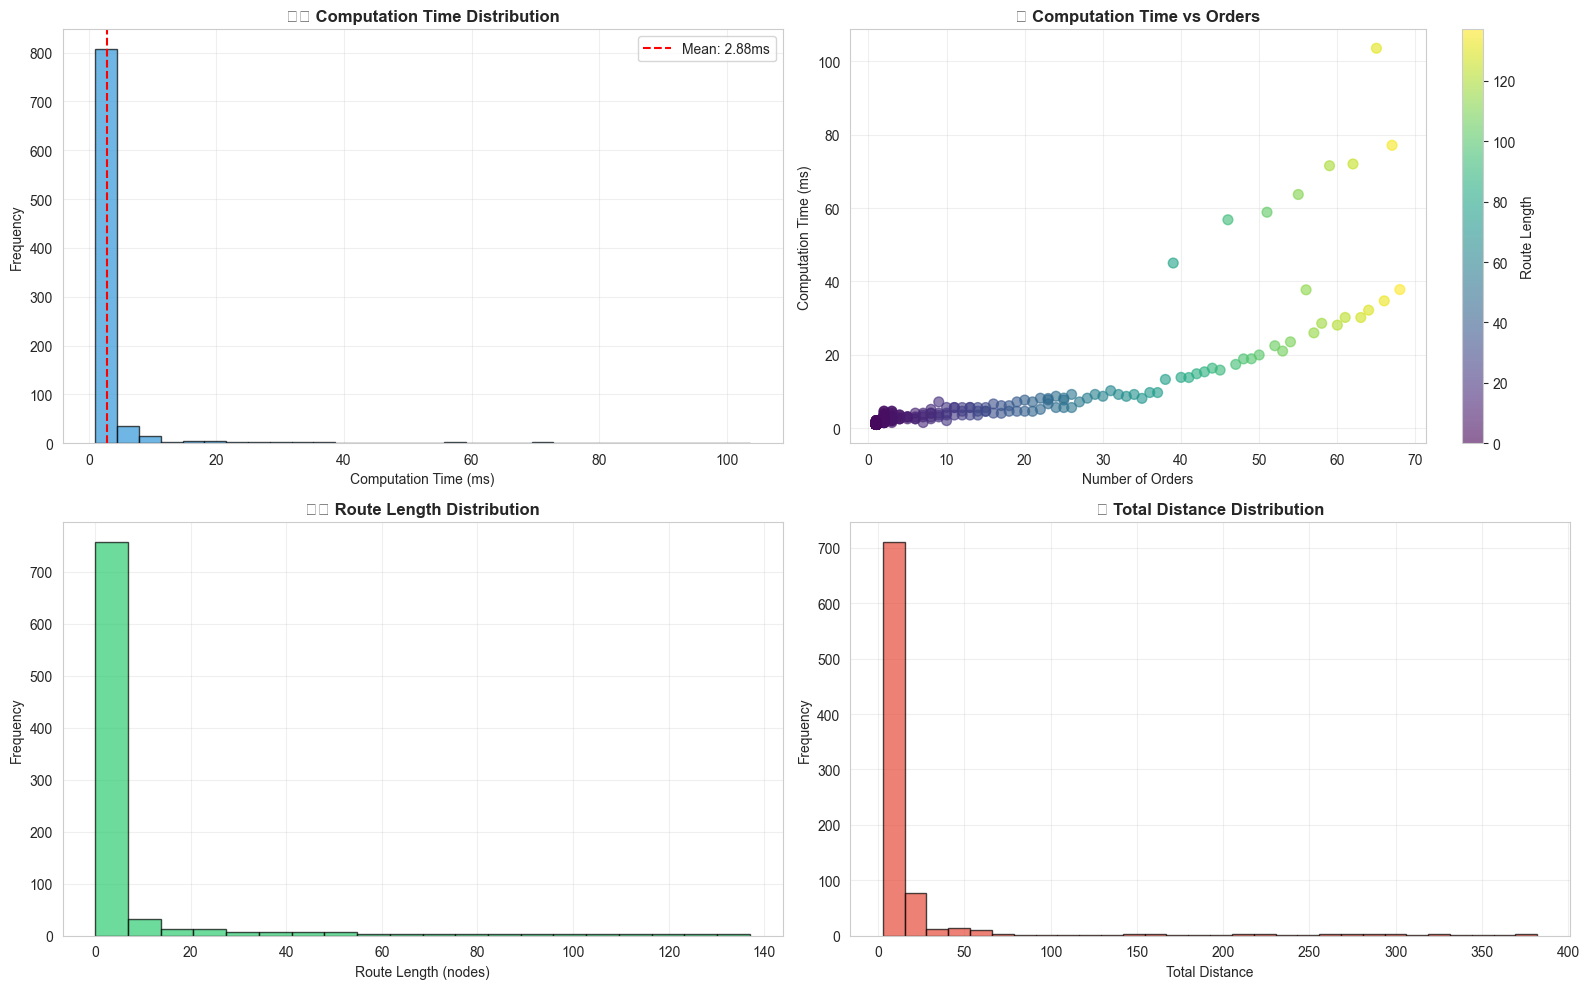

In [11]:
# A* Algorithm Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Computation time distribution
ax = axes[0, 0]
ax.hist(routes['computation_time_ms'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
ax.axvline(routes['computation_time_ms'].mean(), color='red', linestyle='--',
           label=f'Mean: {routes["computation_time_ms"].mean():.2f}ms')
ax.set_xlabel('Computation Time (ms)')
ax.set_ylabel('Frequency')
ax.set_title('⏱️ Computation Time Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Computation time vs number of orders
ax = axes[0, 1]
routes_with_orders = routes[routes['num_orders'] > 0]
if len(routes_with_orders) > 0:
    scatter = ax.scatter(
        routes_with_orders['num_orders'],
        routes_with_orders['computation_time_ms'],
        c=routes_with_orders['route_length'],
        cmap='viridis',
        alpha=0.6,
        s=50
    )
    ax.set_xlabel('Number of Orders')
    ax.set_ylabel('Computation Time (ms)')
    ax.set_title('📦 Computation Time vs Orders', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=ax, label='Route Length')
    ax.grid(alpha=0.3)

# Route length distribution
ax = axes[1, 0]
ax.hist(routes['route_length'], bins=20, color='#2ecc71', alpha=0.7, edgecolor='black')
ax.set_xlabel('Route Length (nodes)')
ax.set_ylabel('Frequency')
ax.set_title('🛣️ Route Length Distribution', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Total distance distribution
ax = axes[1, 1]
ax.hist(routes['total_distance'], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
ax.set_xlabel('Total Distance')
ax.set_ylabel('Frequency')
ax.set_title('📏 Total Distance Distribution', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# 🚗 Route Calculation Performance

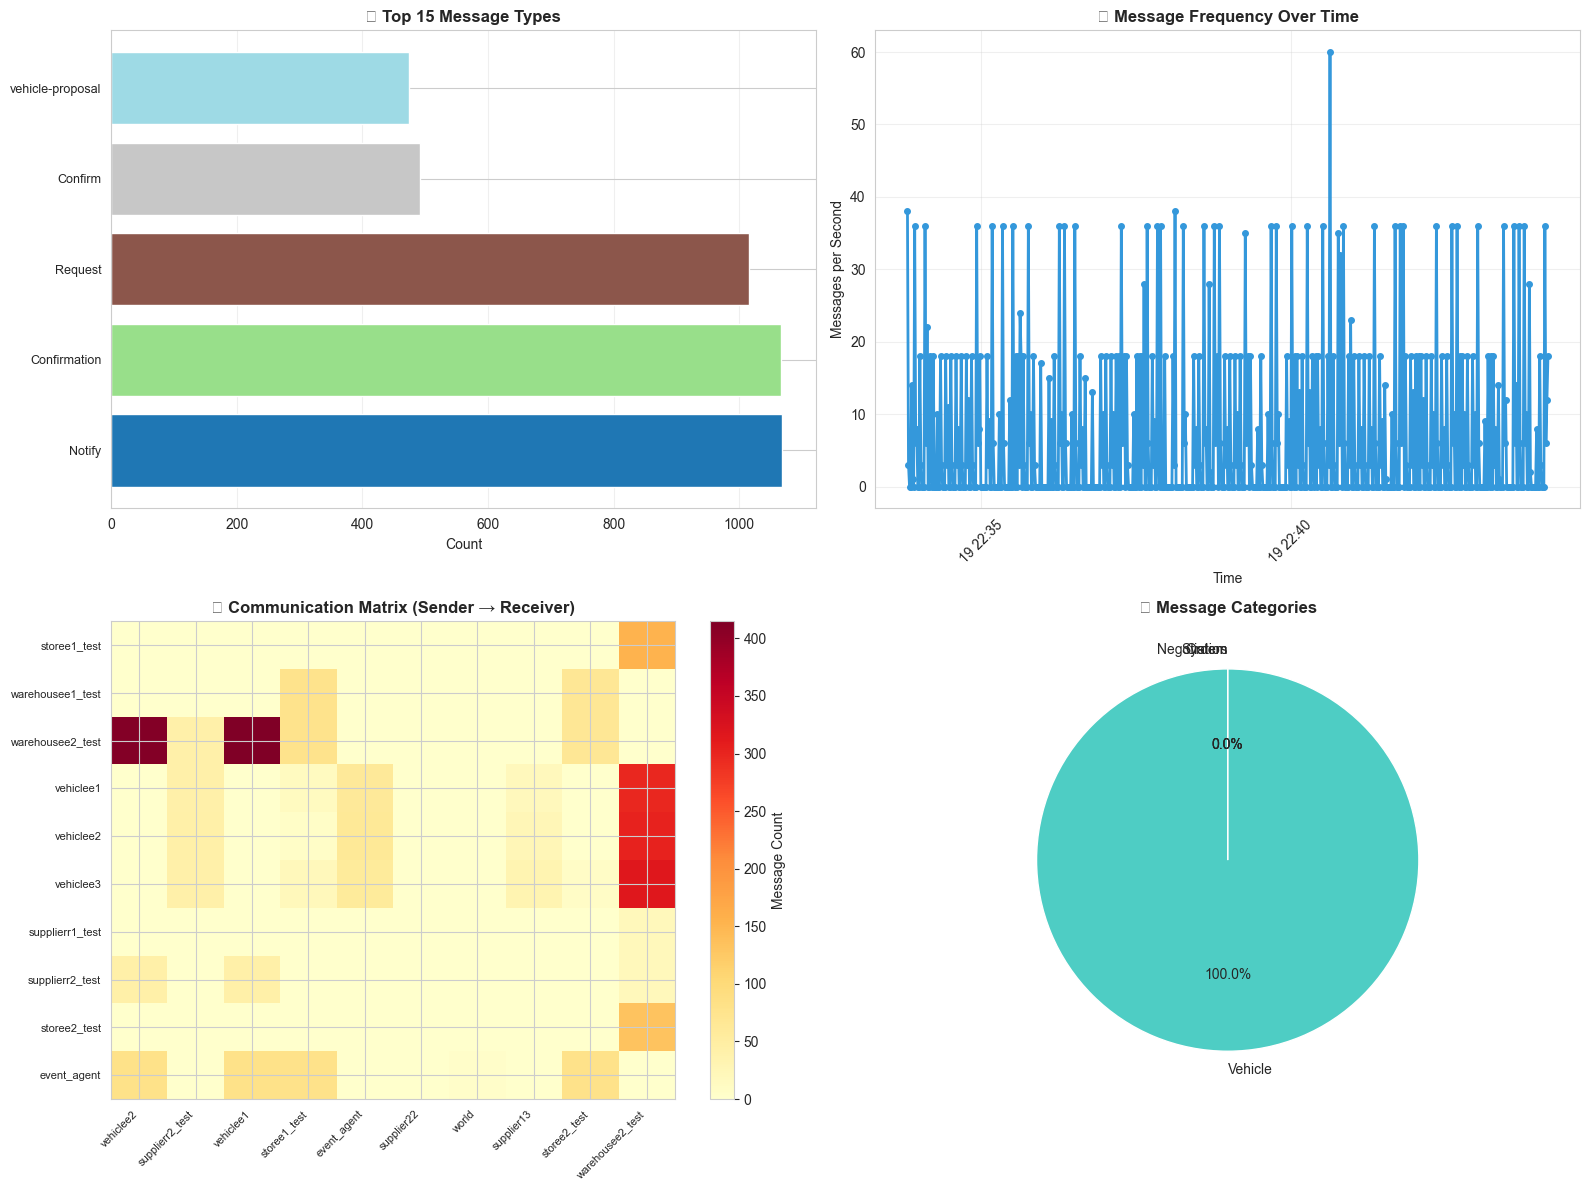


📨 Message Statistics:
   Total messages: 4115
   Unique message types: 5
   Unique senders: 11
   Unique receivers: 13


In [25]:
# Message Type Distribution and Flow
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Message type distribution
msg_types = messages['message_type'].value_counts().head(15)
axes[0, 0].barh(range(len(msg_types)), msg_types.values, 
                color=plt.cm.tab20(np.linspace(0, 1, len(msg_types))))
axes[0, 0].set_yticks(range(len(msg_types)))
axes[0, 0].set_yticklabels(msg_types.index, fontsize=9)
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_title('📨 Top 15 Message Types', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Messages over time
messages['timestamp_real'] = pd.to_datetime(messages['timestamp_real'])
messages_timeline = messages.set_index('timestamp_real').resample('1s').size()
axes[0, 1].plot(messages_timeline.index, messages_timeline.values, 
                color='#3498db', linewidth=2, marker='o', markersize=4)
axes[0, 1].set_title('📈 Message Frequency Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Messages per Second')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Sender-Receiver Matrix (Top agents)
from collections import defaultdict
comm_matrix = defaultdict(lambda: defaultdict(int))
for _, row in messages.iterrows():
    sender = str(row['sender']).split('@')[0]
    receiver = str(row['receiver']).split('@')[0]
    comm_matrix[sender][receiver] += 1

# Convert to DataFrame
senders = list(comm_matrix.keys())[:10]  # Top 10 senders
receivers = list(set([r for s in senders for r in comm_matrix[s].keys()]))[:10]
matrix_data = [[comm_matrix[s].get(r, 0) for r in receivers] for s in senders]

im = axes[1, 0].imshow(matrix_data, cmap='YlOrRd', aspect='auto')
axes[1, 0].set_xticks(range(len(receivers)))
axes[1, 0].set_yticks(range(len(senders)))
axes[1, 0].set_xticklabels(receivers, rotation=45, ha='right', fontsize=8)
axes[1, 0].set_yticklabels(senders, fontsize=8)
axes[1, 0].set_title('🔄 Communication Matrix (Sender → Receiver)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1, 0], label='Message Count')

# Message categories
categories = {
    'Negotiation': ['store-buy', 'warehouse-accept', 'warehouse-reject', 'store-confirm', 'store-deny'],
    'Vehicle': ['vehicle-proposal', 'order-confirmation', 'vehicle-pickup', 'vehicle-delivery'],
    'System': ['inform', 'presence-info', 'presence-response'],
    'Orders': ['order-proposal', 'supplier-accept', 'warehouse-buy']
}

category_counts = {}
for cat, msg_list in categories.items():
    count = messages[messages['message_type'].isin(msg_list)].shape[0]
    category_counts[cat] = count

axes[1, 1].pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%',
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3'], startangle=90)
axes[1, 1].set_title('📊 Message Categories', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📨 Message Statistics:")
print(f"   Total messages: {len(messages)}")
print(f"   Unique message types: {messages['message_type'].nunique()}")
print(f"   Unique senders: {messages['sender'].nunique()}")
print(f"   Unique receivers: {messages['receiver'].nunique()}")

# 📨 Message Communication Analysis

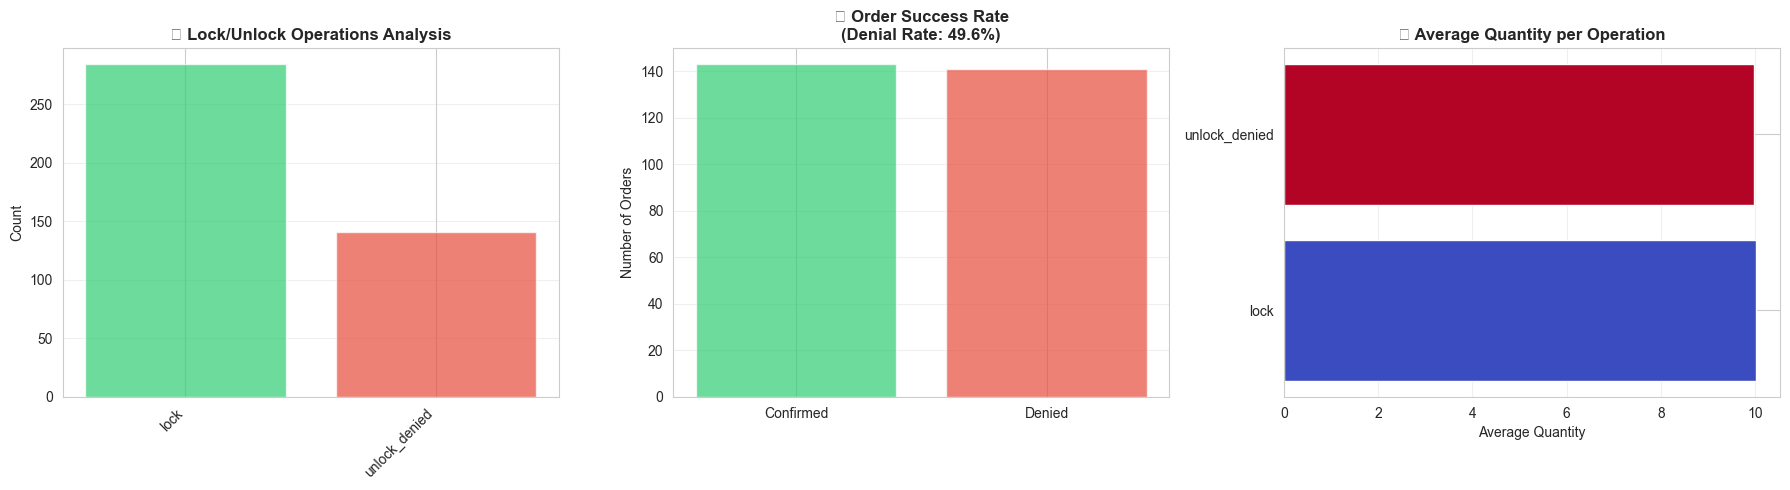


🔒 Lock/Unlock Statistics:
   Total locks: 284
   Confirmed orders: 143
   Denied orders: 141
   Denial rate: 49.65%


In [26]:
# Lock/Unlock Analysis - Warehouse Efficiency
warehouse_only = inventory[inventory['agent_type'] == 'warehouse'].copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Lock vs Unlock efficiency
lock_unlock = warehouse_only['change_type'].value_counts()
lock_types = [ct for ct in lock_unlock.index if 'unlock' in ct or 'lock' in ct]
lock_data = [lock_unlock.get(lt, 0) for lt in lock_types]

axes[0].bar(range(len(lock_types)), lock_data, color=['#2ECC71', '#E74C3C', '#F39C12'], alpha=0.7)
axes[0].set_xticks(range(len(lock_types)))
axes[0].set_xticklabels(lock_types, rotation=45, ha='right')
axes[0].set_title('🔒 Lock/Unlock Operations Analysis', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Calculate denial rate
locks = lock_unlock.get('lock', 0)
denials = lock_unlock.get('unlock_denied', 0) + lock_unlock.get('unlock_timeout', 0)
denial_rate = (denials / locks * 100) if locks > 0 else 0

axes[1].bar(['Confirmed', 'Denied'], [locks - denials, denials], 
            color=['#2ECC71', '#E74C3C'], alpha=0.7)
axes[1].set_title(f'✅ Order Success Rate\n(Denial Rate: {denial_rate:.1f}%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Orders')
axes[1].grid(axis='y', alpha=0.3)

# Average quantity per operation type
avg_qty = warehouse_only.groupby('change_type')['quantity'].mean().sort_values(ascending=False)
axes[2].barh(avg_qty.index, avg_qty.values, color=plt.cm.coolwarm(np.linspace(0, 1, len(avg_qty))))
axes[2].set_xlabel('Average Quantity')
axes[2].set_title('📊 Average Quantity per Operation', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🔒 Lock/Unlock Statistics:")
print(f"   Total locks: {locks}")
print(f"   Confirmed orders: {locks - denials}")
print(f"   Denied orders: {denials}")
print(f"   Denial rate: {denial_rate:.2f}%")

NameError: name 'colors' is not defined

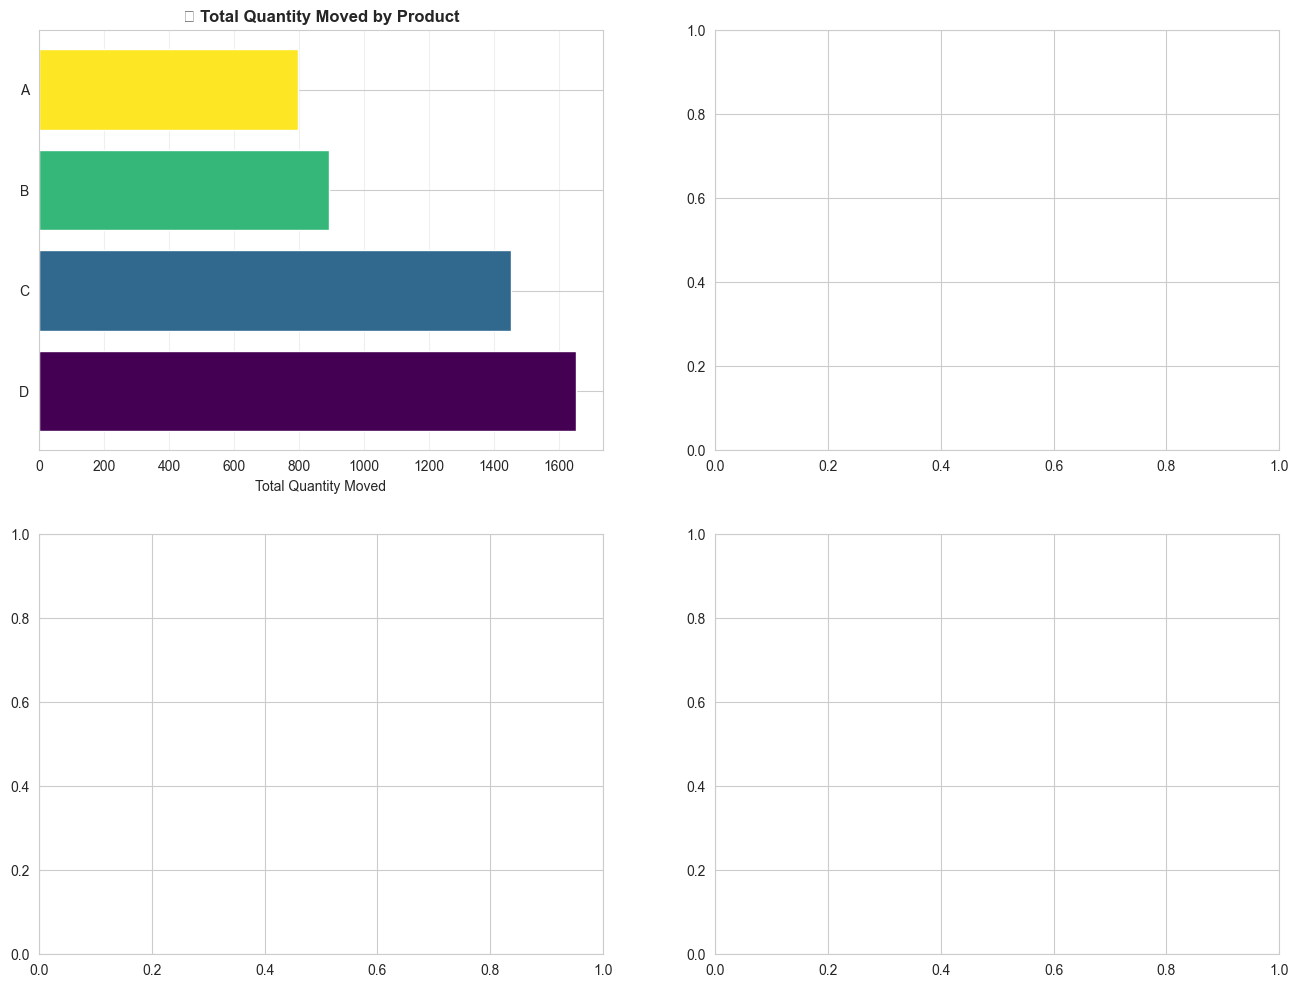

In [27]:
# Product-wise Inventory Movement
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Product distribution
product_counts = inventory.groupby('product')['quantity'].sum().sort_values(ascending=False)
axes[0, 0].barh(product_counts.index, product_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(product_counts))))
axes[0, 0].set_xlabel('Total Quantity Moved')
axes[0, 0].set_title('📦 Total Quantity Moved by Product', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Product by change type
product_change = inventory.groupby(['product', 'change_type'])['quantity'].sum().unstack(fill_value=0)
product_change.plot(kind='bar', stacked=True, ax=axes[0, 1], color=colors, alpha=0.8)
axes[0, 1].set_title('📊 Product Movement by Change Type', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Quantity')
axes[0, 1].set_xlabel('Product')
axes[0, 1].legend(title='Change Type', bbox_to_anchor=(1.05, 1))
axes[0, 1].grid(axis='y', alpha=0.3)

# Stock levels over time for warehouses
warehouse_inv = inventory[inventory['agent_type'] == 'warehouse'].copy()
for agent in warehouse_inv['agent_jid'].unique():
    agent_data = warehouse_inv[warehouse_inv['agent_jid'] == agent]
    axes[1, 0].plot(range(len(agent_data)), agent_data['stock_after'], 
                    label=agent.split('@')[0], marker='o', markersize=3, alpha=0.7)
axes[1, 0].set_title('🏭 Warehouse Stock Levels Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Transaction #')
axes[1, 0].set_ylabel('Stock Level')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(alpha=0.3)

# Store deliveries timeline
store_inv = inventory[inventory['agent_type'] == 'store']
if len(store_inv) > 0:
    store_deliveries = store_inv.groupby('agent_jid')['quantity'].sum().sort_values(ascending=False)
    axes[1, 1].bar(range(len(store_deliveries)), store_deliveries.values, 
                   color=plt.cm.plasma(np.linspace(0, 1, len(store_deliveries))), alpha=0.7)
    axes[1, 1].set_xticks(range(len(store_deliveries)))
    axes[1, 1].set_xticklabels([x.split('@')[0] for x in store_deliveries.index], rotation=45, ha='right')
    axes[1, 1].set_title('🏪 Total Deliveries by Store', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Total Quantity Received')
    axes[1, 1].grid(axis='y', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No store data available', ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

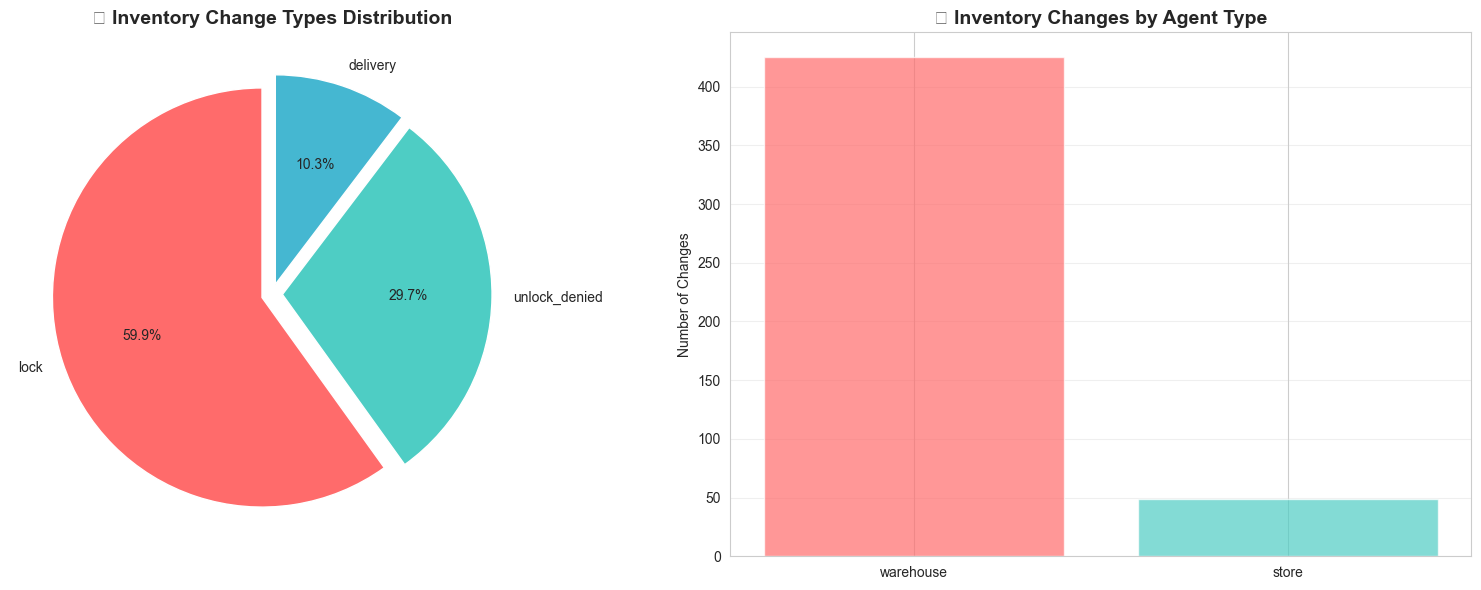


📊 Inventory Change Summary:
   Total changes: 474
   Warehouses: 425
   Stores: 49


In [28]:
# Inventory Change Types Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By change type
change_counts = inventory['change_type'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
axes[0].pie(change_counts.values, labels=change_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=[0.05]*len(change_counts))
axes[0].set_title('📊 Inventory Change Types Distribution', fontsize=14, fontweight='bold')

# By agent type
agent_counts = inventory['agent_type'].value_counts()
axes[1].bar(agent_counts.index, agent_counts.values, color=['#FF6B6B', '#4ECDC4'], alpha=0.7)
axes[1].set_title('🏢 Inventory Changes by Agent Type', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Changes')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Inventory Change Summary:")
print(f"   Total changes: {len(inventory)}")
print(f"   Warehouses: {len(inventory[inventory['agent_type'] == 'warehouse'])}")
print(f"   Stores: {len(inventory[inventory['agent_type'] == 'store'])}")

# 📦 Inventory Analysis